In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0  1527k      0 --:--:-- --:--:-- --:--:-- 1534k
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [25]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
names = [item[0] for item in colors_rgb]

In [0]:
## colors_rgb is the list containing the color name and the values of all
## these colors
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [28]:
## targets is the combination of these three color values
targets

array([[0.68235294, 0.71372549, 0.34117647],
       [0.34509804, 0.20392157, 0.00392157],
       [0.87058824, 0.92941176, 0.84313725],
       ...,
       [0.64705882, 0.70588235, 0.66666667],
       [0.03529412, 0.21176471, 0.14117647],
       [0.6745098 , 0.43921569, 0.41960784]])

In [0]:
# split the train and test dataset
y_train = targets[:int(targets.shape[0]*0.8)]
x_train = names[:int(len(names)*0.8)]

y_test = targets[int(targets.shape[0]*0.8):]
x_test = names[int(len(names)*0.8):]

In [0]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(x_train)
tokenized = t.texts_to_sequences(x_train)
# padding is at the beginning of the sentences, but could change the settlment 
# by changing the padding = 'post'
x_train = pad_sequences(tokenized, maxlen=maxlen)
x_train = x_train.astype('float32')

In [34]:
x_train

array([[ 0.,  0.,  0., ...,  1.,  1.,  9.],
       [ 0.,  0.,  0., ...,  8., 20.,  6.],
       [ 0.,  0.,  0., ..., 12., 10., 16.],
       ...,
       [ 0.,  0.,  0., ...,  5.,  8.,  6.],
       [ 0.,  0.,  0., ...,  2., 24.,  1.],
       [ 0.,  0.,  0., ...,  3.,  1., 13.]], dtype=float32)

In [35]:
print(y_train.shape), print(y_test.shape)

(11325, 3)
(2832, 3)


(None, None)

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
# FIX ME
# This simple model will work
# but won't make useful predictions
# return_sequences = True: 1. to stack the RNN celle, 
# 2. generate the classification results in each step
# default is to set the return_sequences = False, which 
# only return the hidden sequence in the last state
model.add(tf.keras.layers.LSTM(128, return_sequences=True,kernel_initializer='random_normal', bias_initializer='random_normal'))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 25)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 128)            78848     
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 218,883
Trainable params: 218,883
Non-trainable params: 0
_________________________________________________________________


In [37]:
# we're going to massively overfit on the training
# data... that's fine for this experiment
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
319/319 [==============================] - 27s 83ms/step - loss: 0.0630 - acc: 0.6097 - val_loss: 0.0620 - val_acc: 0.5940
Epoch 2/5
319/319 [==============================] - 27s 83ms/step - loss: 0.0597 - acc: 0.6502 - val_loss: 0.0598 - val_acc: 0.6178
Epoch 3/5
319/319 [==============================] - 28s 86ms/step - loss: 0.0577 - acc: 0.6594 - val_loss: 0.0584 - val_acc: 0.6125
Epoch 4/5
319/319 [==============================] - 27s 84ms/step - loss: 0.0563 - acc: 0.6631 - val_loss: 0.0583 - val_acc: 0.6117
Epoch 5/5
319/319 [==============================] - 27s 85ms/step - loss: 0.0547 - acc: 0.6655 - val_loss: 0.0580 - val_acc: 0.6152


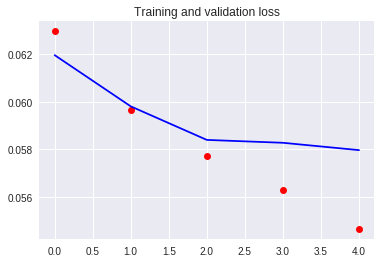

In [38]:
# let's see how badly we've overfit
# (don't worry about it for this assignment)
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo',c = 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

### train another model

In [39]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
# FIX ME
# This simple model will work
# but won't make useful predictions
# return_sequences = True: 1. to stack the RNN celle, 
# 2. generate the classification results in each step
# default is to set the return_sequences = False, which 
# only return the hidden sequence in the last state
model.add(tf.keras.layers.LSTM(128, return_sequences=True,kernel_initializer='random_normal', bias_initializer='random_normal'))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1, 25)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 128)            78848     
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 235,395
Trainable params: 235,395
Non-trainable params: 0
_________________________________________________________________


In [40]:
# we're going to massively overfit on the training
# data... that's fine for this experiment
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
319/319 [==============================] - 27s 86ms/step - loss: 0.0633 - acc: 0.6109 - val_loss: 0.0605 - val_acc: 0.6019
Epoch 2/5
319/319 [==============================] - 27s 86ms/step - loss: 0.0596 - acc: 0.6553 - val_loss: 0.0599 - val_acc: 0.6275
Epoch 3/5
319/319 [==============================] - 27s 86ms/step - loss: 0.0579 - acc: 0.6660 - val_loss: 0.0592 - val_acc: 0.6275
Epoch 4/5
319/319 [==============================] - 27s 86ms/step - loss: 0.0564 - acc: 0.6678 - val_loss: 0.0582 - val_acc: 0.6284
Epoch 5/5
319/319 [==============================] - 29s 90ms/step - loss: 0.0550 - acc: 0.6668 - val_loss: 0.0579 - val_acc: 0.6249


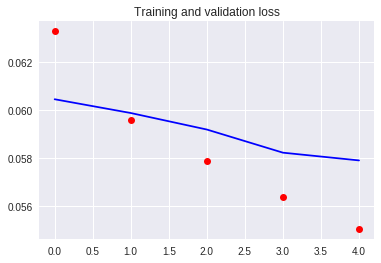

In [41]:
# let's see how badly we've overfit
# (don't worry about it for this assignment)
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo',c = 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

### according to the validation test results, the second model is a bit better

In [42]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
# FIX ME
# This simple model will work
# but won't make useful predictions
# return_sequences = True: 1. to stack the RNN celle, 
# 2. generate the classification results in each step
# default is to set the return_sequences = False, which 
# only return the hidden sequence in the last state
model.add(tf.keras.layers.LSTM(128, return_sequences=True,kernel_initializer='random_normal', bias_initializer='random_normal'))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse', metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=5, validation_split=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 1, 25)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 128)            78848     
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 195       
Total params: 235,395
Trainable params: 235,395
Non-trainable params: 0
_________________________________________________________________
Epoc

### test the model on the test dataset

In [0]:
tokenized = t.texts_to_sequences(x_test)
# padding is at the beginning of the sentences, but could change the settlment 
# by changing the padding = 'post'
x_test = pad_sequences(tokenized, maxlen=maxlen)
x_test = x_test.astype('float32')

In [44]:
score = model.evaluate(x_test, y_test, batch_size=128)

23/23 [==============================] - 1s 41ms/step


In [45]:
print('the test loss is:', score[0])
print('the test accuracy is:',score[1])

the test loss is: 0.05952943869903263
the test accuracy is: 0.6624293785310734


### print the test results

In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    # Check the shapes here if you run into trouble with the next 
    # method after adding your RNN
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

[0.3583377  0.5870414  0.80568224]
light blue, R,G,B: 91 149 205


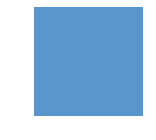

[0.4344066 0.5697644 0.6672176]
blue, R,G,B: 110 145 170


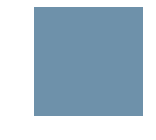

[0.3819579 0.5534416 0.7261582]
dark blue, R,G,B: 97 141 185


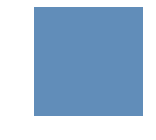

In [49]:
# some "test" data
predict("light blue")
predict("blue")
predict("dark blue")